In [2]:
%pip install opencv-python
%pip install scikit-learn
%pip install matplotlib
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 22.4 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.5/502.5 kB 5.8 MB/s eta 0:00:000m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 kB 4.8 MB/s eta 0:00:000:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
from glob import glob
import cv2
from os.path import basename,exists, join
from os import mkdir
from sklearn.cluster import KMeans
import numpy as np
from pandas import DataFrame


In [4]:
root = "cropped"
paths = glob(join(root,"*.bmp"))
dirs = ["1-I","1-II","1-III","2"]

for dir in dirs:
    if not exists(dir):
        mkdir(dir)
        


# 1 - I

In [29]:
for file in paths:

    imagem = cv2.imread(file)
    altura, largura = imagem.shape[:2]

    # Convertendo a imagem para um array de pixels
    pixels = imagem.reshape((imagem.shape[0] * imagem.shape[1], 3))


    kmeans = KMeans(n_clusters=8, n_init=10)
    kmeans.fit(pixels)

    # Substituindo os pixels pelos valores dos centroides
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_img = segmented_img.reshape(imagem.shape)

    # Convertendo para escala de cinza para aplicar o detector de bordas
    gray_img = cv2.cvtColor(segmented_img.astype(np.uint8), cv2.COLOR_BGR2GRAY)

    # Aplicando o detector de bordas Canny
    edges = cv2.Canny(gray_img, 100, 200)

    outpu2save = join(dirs[0], basename(file))
    
    cv2.imwrite(outpu2save,edges)



# 1 - II

In [30]:
for file in paths:
    
    image = cv2.imread(file,cv2.IMREAD_GRAYSCALE)
    
    # Binarização local usando Niblack
    niblack_binary = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

    # Binarização global usando Otsu
    _, otsu_binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Detecção de bordas por gradiente usando Sobel
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    sobel_edges = np.sqrt(sobel_x**2 + sobel_y**2).astype(np.uint8)

    # Detecção de bordas por gradiente usando Canny
    canny_edges = cv2.Canny(image, 50, 150)


    niblack = join(dirs[1], "niblack_" + basename(file))
    otsu = join(dirs[1], "otsu_" + basename(file))
    sobel = join(dirs[1], "sobel_" + basename(file))
    canny = join(dirs[1], "canny_" + basename(file))
    
    cv2.imwrite(niblack,niblack_binary)
    cv2.imwrite(otsu,otsu_binary)
    cv2.imwrite(sobel,sobel_edges)
    cv2.imwrite(canny,canny_edges)

# 1 - III

In [31]:
for file in paths:
    
    sigma = 1.4
    image = cv2.imread(file,cv2.IMREAD_GRAYSCALE)


    blurred = cv2.GaussianBlur(image, (0, 0), sigma)
    laplacian = cv2.Laplacian(blurred, cv2.CV_64F)

    # Encontrar cruzamentos por zero
    edges = np.zeros_like(laplacian)
    edges[laplacian > 0] = 255

    outpu2save = join(dirs[2], "edges_" + basename(file))

    
    cv2.imwrite(outpu2save,edges)


# 2

In [34]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def automatic_foreground_background_selection(image_path):

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)


    sigma = 1.4
    image_gray = cv2.GaussianBlur(image, (0, 0), sigma)


    pixels = image_gray.reshape((-1, 1))


    kmeans = KMeans(n_clusters=2, random_state=0, n_init=10)
    kmeans.fit(pixels)


    labels = kmeans.labels_


    background_cluster = np.argmax(np.bincount(labels))


    background_mask = (labels == background_cluster).reshape(image.shape[:2])

    # Invertendo a máscara para obter a máscara do foreground
    foreground_mask = ~background_mask


    foreground = cv2.bitwise_and(image, image, mask=foreground_mask.astype(np.uint8))
    background = cv2.bitwise_and(image, image, mask=background_mask.astype(np.uint8))

    return foreground, background

for file in paths:


    foreground, background = automatic_foreground_background_selection(file)
    
    f = join(dirs[3], basename(file) + "foreground.bmp")
    b = join(dirs[3], basename(file) + "background.bmp")

    cv2.imwrite(f,foreground)
    cv2.imwrite(b,background)






# 3

In [9]:
def calculate_iou(true_mask, pred_mask):
    intersection = np.logical_and(true_mask, pred_mask)
    union = np.logical_or(true_mask, pred_mask)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_dice_coefficient(true_mask, pred_mask):
    intersection = np.sum(true_mask * pred_mask)
    dice_coefficient = (2.0 * intersection) / (np.sum(true_mask) + np.sum(pred_mask))
    return dice_coefficient



matriz = [["fname", "iou_score_otsu","dice_score_otsu","iou_score_niblack","dice_score_niblack"]]
for file in paths:
    
    image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)

    _, otsu_binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    niblack_binary = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)


    true_mask = cv2.resize(image, (otsu_binary.shape[1], otsu_binary.shape[0]))

    # Converta para 0 ou 255 (binário)
    true_mask = cv2.threshold(true_mask, 127, 255, cv2.THRESH_BINARY)[1]

    iou_score_otsu = calculate_iou(true_mask, otsu_binary)
    dice_score_otsu = calculate_dice_coefficient(true_mask,otsu_binary)
    
    iou_score_niblack = calculate_iou(true_mask, niblack_binary)
    dice_score_niblack = calculate_dice_coefficient(true_mask,niblack_binary)

    matriz.append([basename(file),iou_score_otsu, dice_score_otsu, iou_score_niblack, dice_score_niblack])
    

df = DataFrame(matriz)

df.to_csv("Comparativo_segmentacao.csv",index=False,header=False)
    


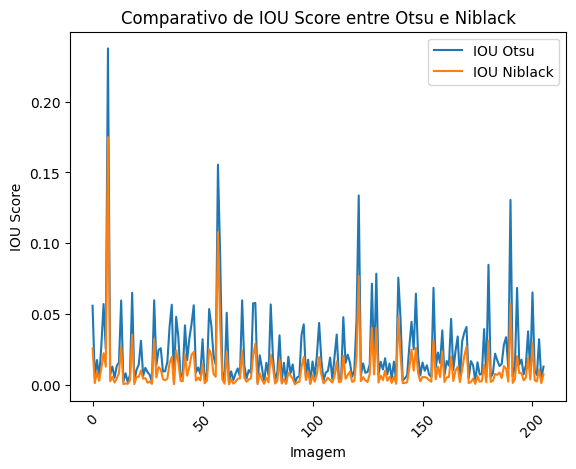

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar dados do CSV para um DataFrame do Pandas
df = pd.read_csv("Comparativo_segmentacao.csv")



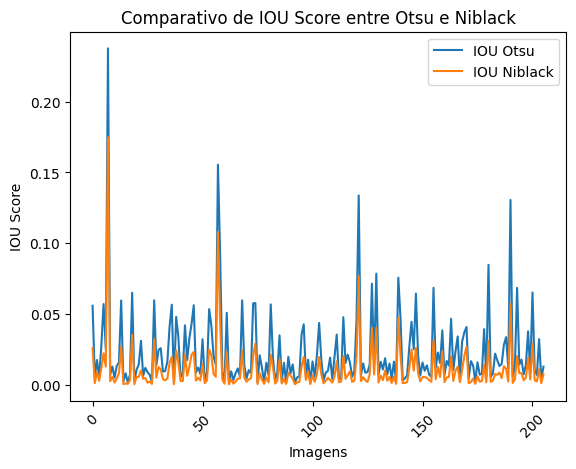

In [12]:
# Criar um gráfico de linhas comparando 'iou_score_otsu' e 'iou_score_niblack'
plt.plot(df['iou_score_otsu'], label='IOU Otsu')
plt.plot(df['iou_score_niblack'], label='IOU Niblack')

# Adicionar rótulos e título ao gráfico
plt.xlabel('Imagens')
plt.ylabel('IOU Score')
plt.title('Comparativo de IOU Score entre Otsu e Niblack')

# Adicionar legenda
plt.legend()

# Rotacionar os rótulos do eixo x para melhor leitura
plt.xticks(rotation=45)

# Mostrar o gráfico
plt.show()


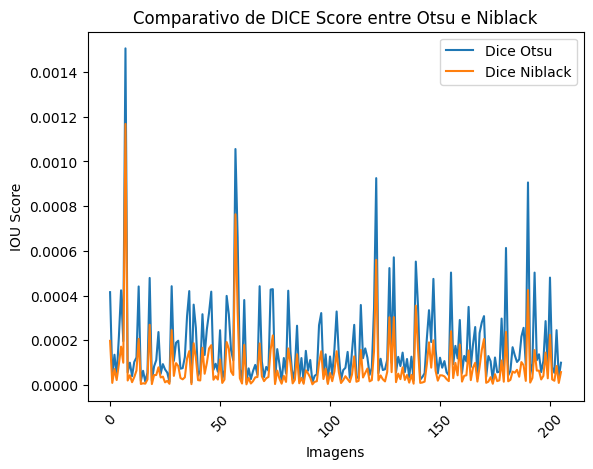

In [15]:
# Criar um gráfico de linhas comparando 'iou_score_otsu' e 'iou_score_niblack'
plt.plot(df['dice_score_otsu'], label='Dice Otsu')
plt.plot(df['dice_score_niblack'], label='Dice Niblack')

# Adicionar rótulos e título ao gráfico
plt.xlabel('Imagens')
plt.ylabel('IOU Score')
plt.title('Comparativo de DICE Score entre Otsu e Niblack')

# Adicionar legenda
plt.legend()

# Rotacionar os rótulos do eixo x para melhor leitura
plt.xticks(rotation=45)

# Mostrar o gráfico
plt.show()
